In [1]:
# Importar bibliotecas
import json
import numpy as np
import pandas as pd

# WordCloud
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Importar o módulo de classificaçao de sentimentos
from sent_classifier import SnorkelSentimentClassifier

pd.set_option('display.max_colwidth', None)

## Suno

In [2]:
# Definir o ticker e importar notícias
ticker = 'PETR4'

In [3]:
# Verificar o dataset importado
with open(f'../crawlers/suno/results/suno-{ticker.lower()}.json', encoding='utf8') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data)
df.sample(5)

,topic,title,date,search_date,url,tags
617,Negócios,"Destaques de Empresas: IRB (IRBR3), Magalu (MGLU3) e Petrobras (PETR4)",14/05/2021 10:46,2022-05-03 16:11:42,https://www.suno.com.br/noticias/destaques-de-empresas-irb-irbr3-magazine-luiza-mglu3-petrobras-per4/,"[destaques de empresas, IRB Brasil (IRBR3), Magazine Luiza (MGLU3), Petrobras (PETR4)]"
1146,Negócios,Petrobras (PETR4) avança nas vendas do campo de Manati e Polo Ceará,08/08/2020 09:13,2022-05-03 16:22:43,https://www.suno.com.br/noticias/petrobras-petr4-vendas-manati-polo-ceara/,"[PETR3, Petrobras (PETR4)]"
357,Negócios,"Radar: Petrobras (PETR4) vai se desfazer de fatia de empresa no Golfo do México, Oi (OIBR3) aprova venda de imóvel e Banco Inter (BIDI4) mantém provisão",04/10/2021 21:11,2022-05-03 16:05:41,https://www.suno.com.br/noticias/radar-petrobras-petr4-oi-oibr3-banco-inter-bidi4/,"[3R Petroleum (RRRP3), B3 (B3SA3), Banco Inter (BIDI11/BIDI4/BIDI3), Enauta (ENAT3), Oi (OIBR3/OIBR4), Petrobras (PETR4), Totvs (TOTS3), Vale (VALE3)]"
712,Negócios,"Petrobras (PETR4) anuncia recompra de até US$ 3,5 bi em títulos globais",31/03/2021 12:56,2022-05-03 16:12:55,https://www.suno.com.br/noticias/petrobras-petr4-recompra-titulos-globais/,[Petrobras (PETR4)]
49,Negócios,Petrobras (PETR4): venda de fatia na Braskem (BRKM5) e novo guidance animam a XP,17/01/2022 20:52,2022-05-03 16:00:00,https://www.suno.com.br/noticias/petrobras-petr4-venda-braskem-xp/,"[Braskem (BRKM3/BRKM5/BRKM6), Especialistas, Petrobras (PETR4)]"


In [4]:
# Selecionar dados de 2020 - Presente

# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

# Set date column as index
df.set_index('date', inplace=True)

# Order by date
df.sort_index(inplace=True)

In [5]:
# Filtrar notícias do tópico 'negócios' para a Suno
# Verificar o similar em MoneyTimes

df = df.loc['2020':,][df['topic'] == 'Negócios']

In [6]:
sc = SnorkelSentimentClassifier(df=df, source='suno')

In [7]:
# Executar o módulo de classificação de sentimentos
df_results, results = sc.apply_rules(df)

100%|██████████| 1500/1500 [00:01<00:00, 1433.60epoch/s]


In [8]:
# Set values to label classes
scores = {"POSITIVE" : 1,
          "NEUTRAL" : 0,
          "NEGATIVE" : -1}

df_results["label_value"] = df_results["label_class"].map(scores)

In [9]:
# Compute scores per publication
df_results['sent_score'] = df_results['label_value'] * 1

In [10]:
scores = pd.DataFrame(df_results.sent_score)
daily_publications = scores.resample('D').nunique()

for index, row in df_results.iterrows():

    # Get sum of daily scores
    index_dt = index.date()
    count_dt = daily_publications.loc[str(index_dt)].values[0]

    # Set new value for sent_score
    df_results.loc[index, 'sent_score'] = row['sent_score'] / count_dt

In [11]:
df_results.tail(10)

,title,title_raw,search_date,label_class,label_value,sent_score
date,,,,,,
2022-04-18 20:38:00,petrobras petr4 acelen investe <NUM> mi para ampliar produção de exrefinaria da estatal,Petrobras (PETR4): Acelen investe R$ 500 mi para ampliar produção de ex-refinaria da estatal,2022-05-03 16:00:30,POSITIVE,1,1.0
2022-04-18 22:01:00,radar sec processa exexecutivo do irb irbr3 ações da rede dor rdor3 em queda há <NUM> dias auren aure3 pagará <NUM> mi em dividendos,"Radar: SEC processa ex-executivo do IRB (IRBR3), ações da Rede D’Or (RDOR3) em queda há 9 dias, Auren (AURE3) pagará R$ 100 mi em dividendos",2022-05-03 16:00:30,POSITIVE,1,1.0
2022-04-22 11:27:00,oi oibr3 banco inter bidi4 e petrobras petr4 são destaques do mercado financeiro,"Oi (OIBR3), Banco Inter (BIDI4) e Petrobras (PETR4) são destaques do mercado financeiro",2022-05-03 16:00:06,NEUTRAL,0,0.0
2022-04-25 20:26:00,petrobras petr4 produção de petróleo e gás sobe <NUM> por cento em março diz anp,"Petrobras (PETR4): produção de petróleo e gás sobe 1,9% em março, diz ANP",2022-05-03 15:59:47,NEUTRAL,0,0.0
2022-04-25 21:31:00,radar musk compra twitter twtr34 minerva beef3 pagará <NUM> mi em dividendos ultrapar ugpa3 quer investimento bilionário em <NUM>,"Radar: Musk compra Twitter (TWTR34), Minerva (BEEF3) pagará R$ 200 mi em dividendos, Ultrapar (UGPA3) quer investimento bilionário em 2022",2022-05-03 15:59:42,POSITIVE,1,0.5
2022-04-27 20:15:00,petrobras petr4 produção total de petróleo e gás sobe <NUM> por cento no 1t22,"Petrobras (PETR4): produção total de petróleo e gás sobe 1,1% no 1T22",2022-05-03 15:59:00,POSITIVE,1,1.0
2022-04-27 22:35:00,radar vale vale3 vê queda no lucro do 1t22 produção da petrobras petr4 sobe movida movi3 paga <NUM> mi em dividendos,"Radar: Vale (VALE3) vê queda no lucro do 1T22, produção da Petrobras (PETR4) sobe, Movida (MOVI3) paga R$ 307 mi em dividendos",2022-05-03 16:00:14,POSITIVE,1,1.0
2022-04-28 15:31:00,petrorio prio3 compra campo da petrobras petr4 na bacia de campos por <NUM> bilhões,"PetroRio (PRIO3) compra campo da Petrobras (PETR4) na Bacia de Campos por US$ 2,2 bilhões",2022-05-03 15:58:25,NEUTRAL,0,0.0
2022-04-29 15:50:00,petrobras petr4 anuncia reajuste de <NUM> por cento no gás natural a partir de domingo,Petrobras (PETR4) anuncia reajuste de 19% no gás natural a partir de domingo,2022-05-03 15:57:53,NEUTRAL,0,0.0


In [12]:
daily_sent_scores = pd.DataFrame(df_results.sent_score.resample('D').sum())

# Mean Normalization
daily_sent_scores = (daily_sent_scores - daily_sent_scores.mean()) / daily_sent_scores.std()

# Min-Max Normalization
# daily_sent_scores = (daily_sent_scores-daily_sent_scores.min()) / (daily_sent_scores.max()-daily_sent_scores.min())
daily_sent_scores = daily_sent_scores.shift().dropna()
daily_sent_scores.to_csv(f'../../data/textual/news/suno_daily_sent_scores_{ticker.lower()}.csv')
daily_sent_scores

,sent_score
date,
2020-07-17,1.277005
2020-07-18,-0.315610
2020-07-19,-0.315610
2020-07-20,-0.315610
2020-07-21,-0.315610
...,...
2022-04-28,6.054849
2022-04-29,-0.315610
2022-04-30,-0.315610


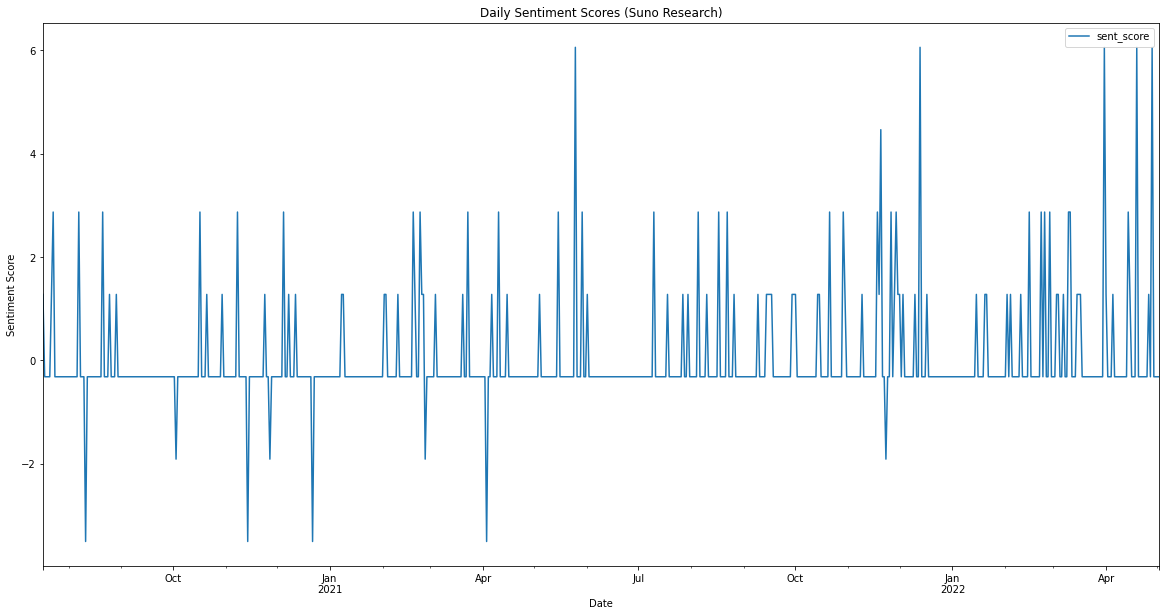

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
daily_sent_scores.plot(ax=ax)
ax.set_title('Daily Sentiment Scores (Suno Research)')
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment Score')
plt.show();

In [14]:
df_results.label_class.value_counts()

NEUTRAL     704
POSITIVE    118
NEGATIVE      9
Name: label_class, dtype: int64

In [15]:
results

,j,Polarity,Coverage,Overlaps,Conflicts
lf_news_good_adjs,0,[1],0.058965,0.006017,0.000000
lf_news_good_verbs,1,[1],0.030084,0.012034,0.001203
lf_regex_dividendos,2,[1],0.048135,0.019254,0.003610
lf_regex_resultado_positivo,3,[1],0.004813,0.002407,0.001203
lf_news_bad_adjs,4,[0],0.006017,0.001203,0.001203
lf_news_bad_verbs,5,[0],0.010830,0.000000,0.000000
lf_regex_resultado_negativo,6,[0],0.016847,0.004813,0.004813


---

### WordClouds

In [16]:
def generate_wordcloud(samples, sentiment, source):

    # Use a image as mask if source is twitter
    twitter_mask = np.array(Image.open("./wordclouds/twitter_mask.png"))

    # concatenar as palavras
    all_words = " ".join(s for s in samples)

    # ver quantidade de palavras
    print("Quantidade de Palavras: {}".format(len(all_words)))

    # lista de stopword
    stopwords = set(STOPWORDS)

    stopwords.update(["de", "e", "a", "um", "que", "com",
                    "só", "da", "do", "m", "a", "ou", "já",
                    "ok", "esse", "ma", "i", "mais", "mas",
                    "não", "meu", "pra", "eu", "uma", "um", 
                    "na", "no", "me", "tem", "em", "por",
                    "ele", "essa", "esse", "se", "vc", "para",
                    "vai", "muito", "minha", "meu", "ele", "ela",
                    "como", "sem", "tá", "dia", "você", "queria",
                    "aqui", "era", "as", "pq", "hoje", "seu", "gente", 
                    "nem", "como", "agora", "os", "quando", "foi", 
                    "isso", "casa", "ser", "ter", "cara", "vou", "NUM"])

    # gerar uma wordcloud
    wordcloud = WordCloud(stopwords=stopwords,
                        background_color="white",
                        max_words=1000,
                        mask=twitter_mask if source == 'twitter' else None,
                        width=1600, 
                        height=800,
                        contour_width=2,
                        collocations=False,
                        contour_color='#1da1f2').generate(all_words)

    # mostrar a imagem final
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()

    plt.imshow(wordcloud);
    
    # salvar a imagem final
    wordcloud.to_file(f"wordclouds/{source}_{sentiment}_wordcloud.png")

    plt.show();

#### Positive Suno

In [17]:
positive_samples = df_results[df_results['label_class'] == 'POSITIVE']['title'].tolist()

Quantidade de Palavras: 10606


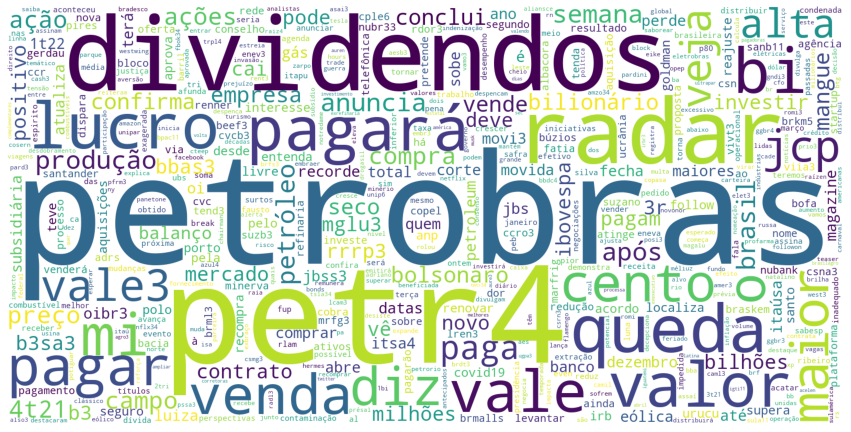

In [18]:
generate_wordcloud(positive_samples, 'positive', 'suno')

#### Negative Suno

In [19]:
negative_samples = df_results[df_results['label_class'] == 'NEGATIVE']['title'].tolist()

Quantidade de Palavras: 661


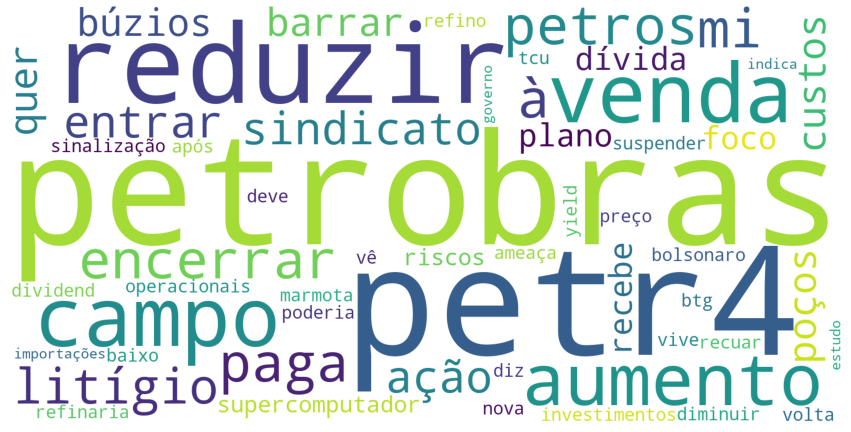

In [20]:
generate_wordcloud(negative_samples, 'negative', 'suno')

---

## Twitter

In [21]:
# Verificar o dataset importado
with open(f'../crawlers/twitter/results/petrobras.json', encoding='utf8') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data)
df.sample(5)

,tweet_id,created_at,search_dt,text,user_id,screen_name,rt_count,favorite_count
11,1519087339548688386,2022-04-26 19:53:39,2022-05-03 14:18:12,"Fique por dentro das principais inovações e transformações que estarão em debate no maior evento de criatividade da América Latina. Acompanhe o RIO2C pelos nossos canais sociais, de 26 de abril a 1 de maio. Esperamos você aqui com muito conteúdo! https://t.co/HL5g7NU27U",45083460,petrobras,2,18
24,1506025711487922181,2022-03-21 18:51:24,2022-05-03 14:18:12,"No Dia Internacional das Florestas, reforçamos nosso compromisso com a biodiversidade brasileira. Em 2021, apoiamos 17 projetos para o fortalecimento de mais de 25 milhões de hectares de áreas protegidas nos biomas Mata Atlântica, Amazônia, Caatinga e Cerrado. https://t.co/X88j9cjb5l",45083460,petrobras,3,18
36,1494370097338667016,2022-02-17 14:56:09,2022-05-03 14:18:12,"Neste primeiro trimestre, doaremos mais de 50 mil auxílios para compra de gás de cozinha e cestas básicas para famílias em situação de vulnerabilidade social em dez estados. Até o final do ano, serão mais de 4 milhões de pessoas beneficiadas. #TodoDiaEDiaDeTransformar https://t.co/knONTR6vDo",45083460,petrobras,3,26
384,1293593791832756227,2020-08-12 14:02:48,2022-05-03 14:18:23,"Conhece alguém que curte o universo maker? 🗜\nOu que gosta muito do @mundobita?🐮 🐔 🙇🏾‍♀️ 🙇🏻‍♂️\n\nEntão marca as @ dos amigos aqui nesse post para que eles não percam esse episódio do @CanalMaker, patrocinado pela Petrobras: https://t.co/lBD4EGstIe\n\n#EnergiaParaTransformar https://t.co/93teByUxF4",45083460,petrobras,5,137
15,1516150205871235074,2022-04-18 17:22:32,2022-05-03 14:18:12,"Se você tem entre 14 e 22 anos, uma nova fase está prestes a começar. E a senha é uma só: Você como Jovem Aprendiz Petrobras. Prepare-se para abrir caminhos e impulsionar a sua vida profissional. Confira o edital em https://t.co/McXmFgANmK e inscreva-se agora mesmo!",45083460,petrobras,7,18


In [22]:
sc = SnorkelSentimentClassifier(df=df, source='twitter')

In [23]:
# Executar o módulo de classificação de sentimentos
df_results, results = sc.apply_rules(df)

100%|██████████| 1500/1500 [00:00<00:00, 1711.06epoch/s]


In [24]:
# Convert date to datetime format
df_results['date'] = pd.to_datetime(df_results['created_at'], format='%Y-%m-%d %H:%M:%S')

# Set date column as index
df_results.set_index('date', inplace=True)

# Order by date
df_results.sort_index(inplace=True)

# Since 2020
df_results = df_results.loc['2020':,]

In [25]:
df_results.tail(10)

,title,title_raw,created_at,search_dt,rt_count,favorite_count,label_class
date,,,,,,,
2022-04-28 17:55:37,a petrobras chegou com tudo no rio2c e no start já contamos com a participação de youtuber do canal ciência todo dia que esteve presente falando sobre inovação na educação confere aí um pouquinho do batepapo exclusivo que tivemos com ele,"A Petrobras chegou com tudo no Rio2C. E no start, já contamos com a participação de @pedroloos, youtuber do canal Ciência Todo Dia que esteve presente falando sobre inovação na educação. Confere aí um pouquinho do bate-papo exclusivo que tivemos com ele. https://t.co/tkTwzxAap3",2022-04-28 17:55:37,2022-05-03 14:18:12,2,18,NEUTRAL
2022-04-28 19:11:55,no dia da educação doamos gás de cozinha e cestas básicas na escola municipal campos elíseos em duque de caxias rj que contou com a presença do nosso presidente josé mauro coelho nessa escola funcionam atividades do instituto unicirco patrocinado pela petrobras,"No Dia da Educação, doamos gás de cozinha e cestas básicas na Escola Municipal Campos Elíseos, em Duque de Caxias (RJ), que contou com a presença do nosso Presidente José Mauro Coelho. Nessa escola, funcionam atividades do Instituto Unicirco, patrocinado pela Petrobras. https://t.co/KfWG4a8b7T",2022-04-28 19:11:55,2022-05-03 14:18:12,4,19,NEUTRAL
2022-04-29 12:01:18,a petrobras levou para o evento o simulador do rov um robô submarino que ajuda na manutenção de equipamentos e estruturas de exploração e produção de petróleo nosso entrevistador marcelo burger viveu essa experiência e vai mostrar um pouco mais para você olha só que incrível,"A Petrobras levou para o evento o simulador do ROV, um robô submarino que ajuda na manutenção de equipamentos e estruturas de exploração e produção de petróleo. Nosso entrevistador Marcelo Burger viveu essa experiência e vai mostrar um pouco mais para você. Olha só que incrível! https://t.co/4ZlyQvgARo",2022-04-29 12:01:18,2022-05-03 14:18:12,4,26,NEGATIVE
2022-04-29 17:17:09,a orquestra petrobras sinfônica também está presente no rio2c mas não do jeito que você imagina acompanhe o marcelo burger e conheça o petrobras sinfônica experience um espaço para vivenciar a música de dentro,"A Orquestra Petrobras Sinfônica também está presente no Rio2C. Mas não do jeito que você imagina. Acompanhe o Marcelo Burger e conheça o Petrobras Sinfônica Experience, um espaço para vivenciar a música de dentro. https://t.co/Qn7Y1cS1vR",2022-04-29 17:17:09,2022-05-03 14:18:12,0,7,NEUTRAL
2022-04-29 19:35:16,na petrobras o futuro mais sustentável já começou e foi sobre isso que a rafaela guedes nossa gerente de responsabilidade social falou durante sua palestra no rio2c e nesse papo exclusivo com o entrevistador marcelo burger,"Na Petrobras, o futuro mais sustentável já começou. E foi sobre isso que a Rafaela Guedes, nossa Gerente de Responsabilidade Social, falou durante sua palestra no Rio2C e nesse papo exclusivo com o entrevistador Marcelo Burger. https://t.co/BXVboepfpL",2022-04-29 19:35:16,2022-05-03 14:18:12,3,20,NEUTRAL
2022-04-30 14:31:15,promover mudanças através da tecnologia de startups esse é o principal objetivo do conexões para a inovação segundo alex dal pont gerente de inovação e responsável pelo programa já são <NUM> projetos apoiados pela petrobras e testados em diferentes lugares do país,"Promover mudanças através da tecnologia de startups: esse é o principal objetivo do Conexões para a Inovação. Segundo Alex Dal Pont, Gerente de Inovação e responsável pelo programa, já são 37 projetos apoiados pela Petrobras e testados em diferentes lugares do país. https://t.co/bipSffv1hb",2022-04-30 14:31:15,2022-05-03 14:18:12,5,16,POSITIVE
2022-05-01 10:04:46,música também é inovação que transforma por isso a orquestra petrobras sinfônica marcou presença no o maestro felipe prazeres fala sobre os desafios para produzir um conserto para novos públicos e cada vez mais inovador vem saber mais sobre o espetáculo no vídeo,"Música também é inovação que transforma! Por i

In [26]:
df_results.label_class.value_counts()

NEUTRAL     265
POSITIVE    133
NEGATIVE     21
Name: label_class, dtype: int64

In [27]:
results

,j,Polarity,Coverage,Overlaps,Conflicts
lf_news_good_adjs,0,[1],0.288095,0.033333,0.016667
lf_news_good_verbs,1,[1],0.045238,0.016667,0.002381
lf_regex_dividendos,2,[],0.000000,0.000000,0.000000
lf_regex_resultado_positivo,3,[1],0.002381,0.002381,0.000000
lf_news_bad_adjs,4,[0],0.050000,0.011905,0.011905
lf_news_bad_verbs,5,[0],0.019048,0.007143,0.007143
lf_regex_resultado_negativo,6,[],0.000000,0.000000,0.000000


### WordClouds

#### Positive Twitter

In [28]:
positive_samples = df_results[df_results['label_class'] == 'POSITIVE']['title'].tolist()

Quantidade de Palavras: 27007


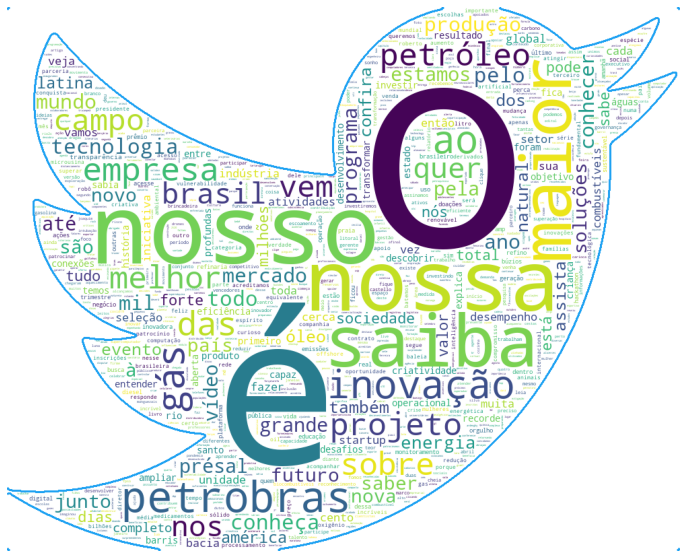

In [29]:
generate_wordcloud(positive_samples, 'positive', 'twitter')

#### Negative Twitter

In [30]:
negative_samples = df_results[df_results['label_class'] == 'NEGATIVE']['title'].tolist()

Quantidade de Palavras: 4651


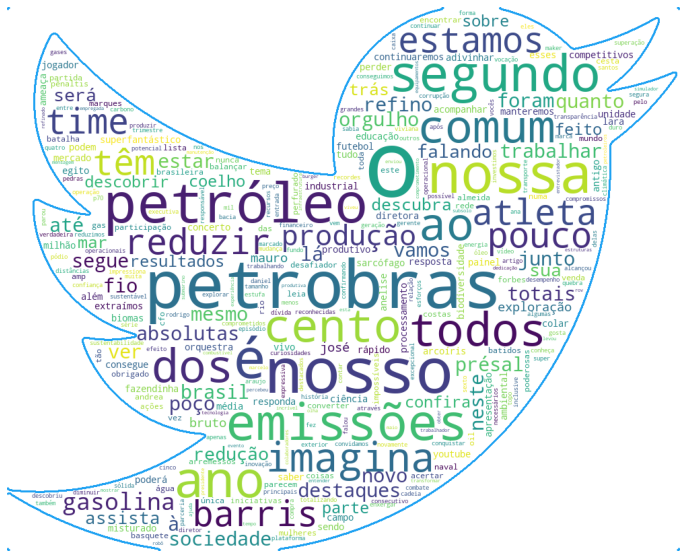

In [31]:
generate_wordcloud(negative_samples, 'negative', 'twitter')

---

## Aggregate Sentiment Scores

#### Using RTs e Favorite Count

In [32]:
df_results.head(2)

,title,title_raw,created_at,search_dt,rt_count,favorite_count,label_class
date,,,,,,,
2020-07-03 16:46:40,a inteligência artificial vem ajudando médicos no diagnóstico do coronavírus com a nossa parceria o desenvolveu uma ia inédita que identifica indícios de covid19 em exames de tomografia e raiox saiba,"A inteligência artificial vem ajudando médicos no diagnóstico do coronavírus. Com a nossa parceria, o @hospitalHCFMUSP desenvolveu, uma I.A inédita que identifica indícios de Covid-19 em exames de tomografia e raio-X. Saiba: https://t.co/tUEBXhz322 https://t.co/egf3gxJPYq",2020-07-03 16:46:40,2022-05-03 14:18:23,20,112,NEUTRAL
2020-07-08 10:05:10,sabia que estimulando a imaginação das crianças você gera adultos mais inteligentes leia mais sobre isso aqui e descubra como o para crianças está ajudando,Sabia que estimulando a imaginação das crianças você gera adultos mais inteligentes? Leia mais sobre isso aqui https://t.co/XsGkeViii5 e descubra como o #PetrobrasCultural para Crianças está ajudando. #EnergiaParaTransformar #JuntosNossaEnergiaFicaMaisForte https://t.co/WhRqc1RGL6,2020-07-08 10:05:10,2022-05-03 14:18:23,5,65,NEUTRAL


In [33]:
# Set values to label classes
scores = {"POSITIVE" : 1,
          "NEUTRAL" : 0,
          "NEGATIVE" : -1}

df_results["label_value"] = df_results["label_class"].map(scores)

In [34]:
df_results.head(2)

,title,title_raw,created_at,search_dt,rt_count,favorite_count,label_class,label_value
date,,,,,,,,
2020-07-03 16:46:40,a inteligência artificial vem ajudando médicos no diagnóstico do coronavírus com a nossa parceria o desenvolveu uma ia inédita que identifica indícios de covid19 em exames de tomografia e raiox saiba,"A inteligência artificial vem ajudando médicos no diagnóstico do coronavírus. Com a nossa parceria, o @hospitalHCFMUSP desenvolveu, uma I.A inédita que identifica indícios de Covid-19 em exames de tomografia e raio-X. Saiba: https://t.co/tUEBXhz322 https://t.co/egf3gxJPYq",2020-07-03 16:46:40,2022-05-03 14:18:23,20,112,NEUTRAL,0.0
2020-07-08 10:05:10,sabia que estimulando a imaginação das crianças você gera adultos mais inteligentes leia mais sobre isso aqui e descubra como o para crianças está ajudando,Sabia que estimulando a imaginação das crianças você gera adultos mais inteligentes? Leia mais sobre isso aqui https://t.co/XsGkeViii5 e descubra como o #PetrobrasCultural para Crianças está ajudando. #EnergiaParaTransformar #JuntosNossaEnergiaFicaMaisForte https://t.co/WhRqc1RGL6,2020-07-08 10:05:10,2022-05-03 14:18:23,5,65,NEUTRAL,0.0


In [35]:
# Compute scores per publication
df_results['sent_score'] = df_results['label_value'] * (10 * df_results['rt_count']) #+ df_results['favorite_count']

In [36]:
df_results.head(10)

,title,title_raw,created_at,search_dt,rt_count,favorite_count,label_class,label_value,sent_score
date,,,,,,,,,
2020-07-03 16:46:40,a inteligência artificial vem ajudando médicos no diagnóstico do coronavírus com a nossa parceria o desenvolveu uma ia inédita que identifica indícios de covid19 em exames de tomografia e raiox saiba,"A inteligência artificial vem ajudando médicos no diagnóstico do coronavírus. Com a nossa parceria, o @hospitalHCFMUSP desenvolveu, uma I.A inédita que identifica indícios de Covid-19 em exames de tomografia e raio-X. Saiba: https://t.co/tUEBXhz322 https://t.co/egf3gxJPYq",2020-07-03 16:46:40,2022-05-03 14:18:23,20,112,NEUTRAL,0.0,0.0
2020-07-08 10:05:10,sabia que estimulando a imaginação das crianças você gera adultos mais inteligentes leia mais sobre isso aqui e descubra como o para crianças está ajudando,Sabia que estimulando a imaginação das crianças você gera adultos mais inteligentes? Leia mais sobre isso aqui https://t.co/XsGkeViii5 e descubra como o #PetrobrasCultural para Crianças está ajudando. #EnergiaParaTransformar #JuntosNossaEnergiaFicaMaisForte https://t.co/WhRqc1RGL6,2020-07-08 10:05:10,2022-05-03 14:18:23,5,65,NEUTRAL,0.0,0.0
2020-07-08 16:06:02,sabe a vontade de inovar que não sossega até achar a solução a gente também por isso somos parceiros da há <NUM> anos veja mais aqui,Sabe a vontade de inovar que não sossega até achar a solução? A gente também. Por isso somos parceiros da @CampusPartyBRA há 9 anos.\nVeja mais aqui https://t.co/Q9FTCgIu6C #DiadaCiência #DiadoPesquisadorCientífico #CampusPartyDigitalEdition #CPDE https://t.co/7FsABd0P1j,2020-07-08 16:06:02,2022-05-03 14:18:23,52,547,NEUTRAL,0.0,0.0
2020-07-09 09:52:10,cuidados com a vida marinha veja o recado do bartolomeu veterinário do projeto de monitoramento das praias saiba mais nilson coelho pmpbs,"Cuidados com a vida marinha: veja o recado do Bartolomeu, veterinário do Projeto de Monitoramento das Praias. Saiba mais: https://t.co/VlQ3Pem9TZ\n📷: Nilson Coelho, PMP-BS\n#EnergiaParaTransformar\n#JuntosNossaEnergiaFicaMaisForte\n------------------------------ https://t.co/npt5i0pN24",2020-07-09 09:52:10,2022-05-03 14:18:23,6,88,NEUTRAL,0.0,0.0
2020-07-09 11:36:02,doamos junto com a br distribuidora <NUM> mil litros de combustíveis para apoio no combate à covid19 em mg pr e ce o combustível abastecerá hospitais ambulâncias e carros de serviço da rede pública de saúde saiba mais em,"Doamos junto com a BR Distribuidora 60 mil litros de combustíveis para apoio no combate à Covid-19 em MG, PR e CE. O combustível abastecerá hospitais, ambulâncias e carros de serviço da rede pública de saúde. Saiba mais em: \nhttps://t.co/s2uq0tX9Ty https://t.co/45071tINvz",2020-07-09 11:36:02,2022-05-03 14:18:23,361,2391,NEUTRAL,0.0,0.0
2020-07-09 16:54:03,no duelo de todo dia hoje o computador ganha fácil da tv começou a se ligue nas novidades e responda ao nosso quiz sobre inovação,No duelo de todo dia hoje o computador ganha fácil da TV. Começou a @CampusPartyBRA ! Se ligue nas novidades e responda ao nosso quiz sobre inovação: https://t.co/Q9FTCgIu6C #EnergiaParaTransformar #CampusPartyDigitalEdition #CPDE https://t.co/0vrvm4VkE3,2020-07-09 16:54:03,2022-05-03 14:18:23,34,465,NEUTRAL,0.0,0.0
2020-07-10 09:55:03,imagina se conectar no maior evento de tecnologia e inovação do mundo fique por dentro do que está rolando na e aproveite para participar do nosso quiz sobre inovação,Imagina se conectar no maior evento de tecnologia e inovação do mundo? Fique por dentro do que está rolando na @CampusPartyBRA e aproveite para participar do nosso quiz sobre inovação: https://t.co/Q9FTCgIu6C #EnergiaParaTransformar\n#CampusPartyDigitalEdition\n#CPDE https://t.co/YC9GLSZB2i,2020-07-10 09:55:03,2022-05-03 14:18:23,68,637,POSITIVE,1.0,680.0
2020-07-10 13:35:12,estamos na hoje às 15h com nosso diretor de transformação digital e inovação nicolas simone falando sobre the world stood still how do we startup the new normal no espaço virtual reiniciando o mundo nã

In [37]:
scores = pd.DataFrame(df_results.sent_score)
daily_publications = scores.resample('D').nunique()

for index, row in df_results.iterrows():

    # Get sum of daily scores
    index_dt = index.date()
    count_dt = daily_publications.loc[str(index_dt)].values[0]

    # Set new value for sent_score
    df_results.loc[index, 'sent_score'] = row['sent_score'] / count_dt

In [38]:
daily_sent_scores = pd.DataFrame(df_results.sent_score.resample('D').sum())

# Mean Normalization
daily_sent_scores = (daily_sent_scores - daily_sent_scores.mean()) / daily_sent_scores.std()

# Min-Max Normalization
#daily_sent_scores = (daily_sent_scores-daily_sent_scores.min())/(daily_sent_scores.max()-daily_sent_scores.min())
daily_sent_scores = daily_sent_scores.shift().dropna()
daily_sent_scores.to_csv(f'../../data/textual/twitter/twitter_daily_sent_scores_{ticker.lower()}.csv')
daily_sent_scores

,sent_score
date,
2020-07-04,-0.156440
2020-07-05,-0.156440
2020-07-06,-0.156440
2020-07-07,-0.156440
2020-07-08,-0.156440
...,...
2022-04-29,-0.156440
2022-04-30,-0.184895
2022-05-01,-0.085302


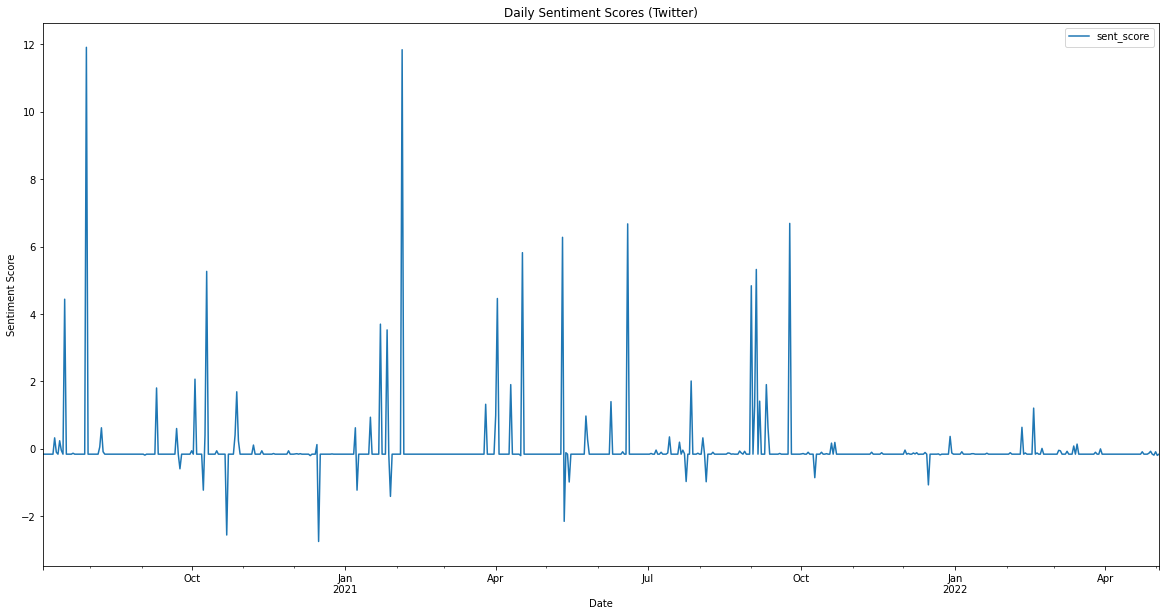

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
daily_sent_scores.plot(ax=ax)
ax.set_title('Daily Sentiment Scores (Twitter)')
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment Score')
plt.show();

---